In [77]:
import imageio
import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import matplotlib as mp
from skimage.exposure import rescale_intensity
import PIL

## 1- Exploring the color spaces


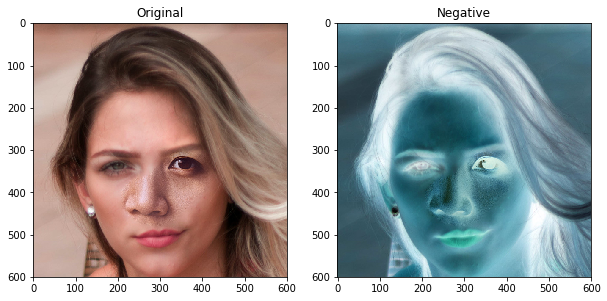

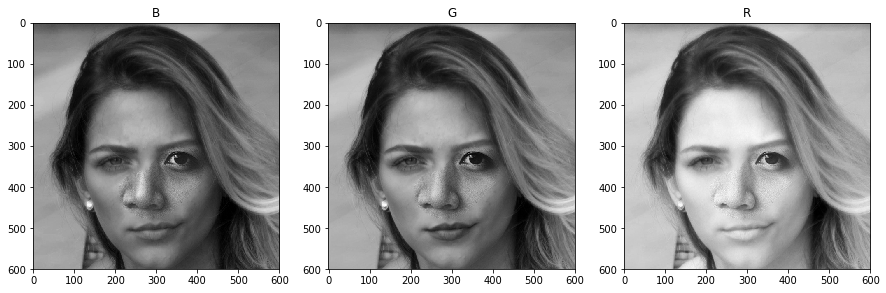

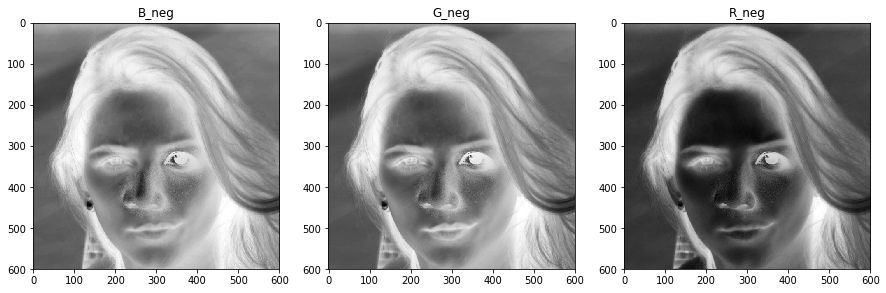

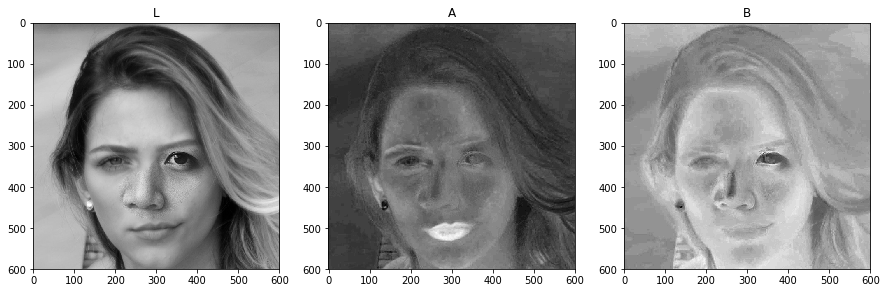

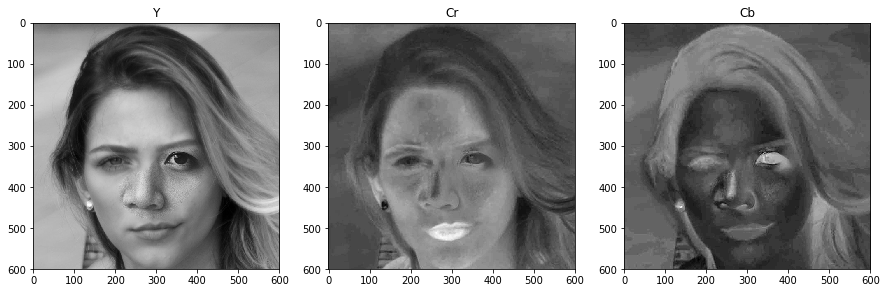

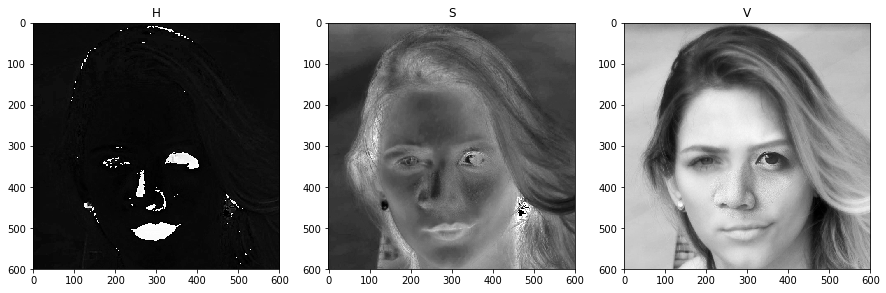

In [267]:
# Load an image
img_path = './data/fake_images/easy_25_0110.jpg'
img_bgr = cv2.imread(img_path)
img_gray = cv2.imread(img_path,0) 

# Convert to other color spaces
img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
img_YCrCb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
img_HSV = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

# Get individual channels
b, g, r = cv2.split(img_bgr)
l, a , b_ = cv2.split(img_lab)
Y, Cr, Cb = cv2.split(img_YCrCb)
H, S, V = cv2.split(img_HSV)

neg_img = cv2.bitwise_not(img_bgr)
b_neg, g_neg, r_neg = cv2.split(neg_img)

colour_spaces = []
colour_spaces.extend((b,g,r,l,a,b,Y,Cr,Cb,H,S,V,b_neg,g_neg,r_neg))
titles = []
titles.extend(('b','g','r','l','a','b','Y','Cr','Cb','H','S','V','b_neg','g_neg', 'r_neg'))

def show():
    plt.figure(figsize=(10,10))
    plt.subplot(121); plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)); plt.title('Original')
    plt.subplot(122); plt.imshow(cv2.cvtColor(neg_img, cv2.COLOR_BGR2RGB)); plt.title('Negative')

    plt.figure(figsize=(15,15))
    plt.subplot(131); plt.imshow(b, cmap='gray'); plt.title('B')
    plt.subplot(132); plt.imshow(g, cmap='gray'); plt.title('G')
    plt.subplot(133); plt.imshow(r, cmap='gray'); plt.title('R')

    plt.figure(figsize=(15,15))
    plt.subplot(131); plt.imshow(b_neg, cmap='gray'); plt.title('B_neg')
    plt.subplot(132); plt.imshow(g_neg, cmap='gray'); plt.title('G_neg')
    plt.subplot(133); plt.imshow(r_neg, cmap='gray'); plt.title('R_neg')

    plt.figure(figsize=(15,15))
    plt.subplot(131); plt.imshow(l, cmap='gray'); plt.title('L')
    plt.subplot(132); plt.imshow(a, cmap='gray'); plt.title('A')
    plt.subplot(133); plt.imshow(b_, cmap='gray'); plt.title('B')

    plt.figure(figsize=(15,15))
    plt.subplot(131); plt.imshow(Y, cmap='gray'); plt.title('Y')
    plt.subplot(132); plt.imshow(Cr, cmap='gray'); plt.title('Cr')
    plt.subplot(133); plt.imshow(Cb, cmap='gray'); plt.title('Cb')

    plt.figure(figsize=(15,15))
    plt.subplot(131); plt.imshow(H, cmap='gray'); plt.title('H')
    plt.subplot(132); plt.imshow(S, cmap='gray'); plt.title('S')
    plt.subplot(133); plt.imshow(V, cmap='gray'); plt.title('V')
    
show()

## 2 - Denoising methods 


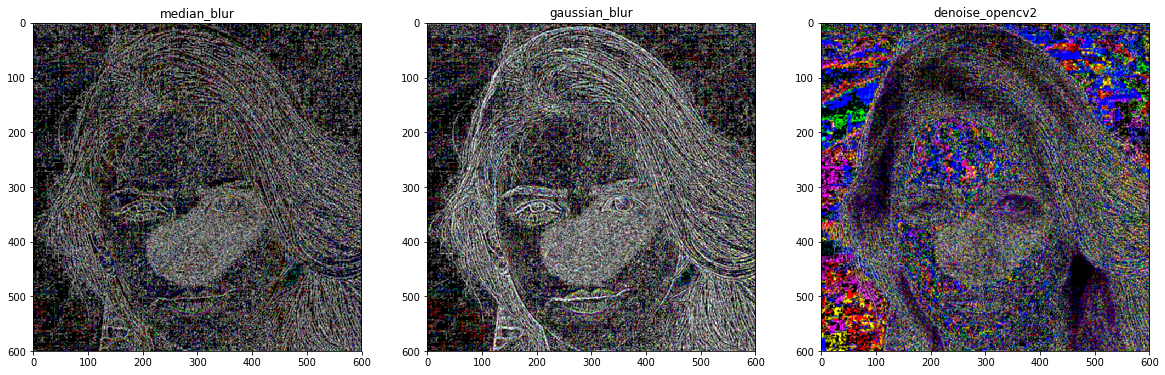

In [268]:
img = img_bgr

# Appling median, gaussian and an opencv blur methods
median_blur = cv2.medianBlur(img,3)
gaussian_blur = cv2.GaussianBlur(img,(3,3),0)
denoise_opencv2 = cv2.fastNlMeansDenoisingColored(img,None,3,3,3,3)

denoise_methods = []
denoise_methods.extend((median_blur, gaussian_blur, denoise_opencv2))
                     
denoise_titles = []
denoise_titles.extend(('median_blur', 'gaussian_blur', 'denoise_opencv2'))
                      

revealed_noises = []
i = 1; j = 0
for denoise_method in denoise_methods:
    
    # Difference between the original image and the denoised image
    revealed_noise = img-denoise_method
    
    revealed_noises.append(revealed_noise)
    
    # Apply some blur to help the visualization
    revealed_noise = cv2.blur(revealed_noise,(3,3))
    

    j = j+1
    
    if (i+2) % 3 == 0:
        plt.figure(figsize=(20,20))  
    plt.subplot('1'+'3'+str(j)); plt.imshow(np.clip(revealed_noise,0,255), cmap='gray'); plt.title(denoise_titles[i-1])
    
    
    if j == 3:
        j = 0
    i = i+1
    

Text(0.5, 1.0, 'After Opening')

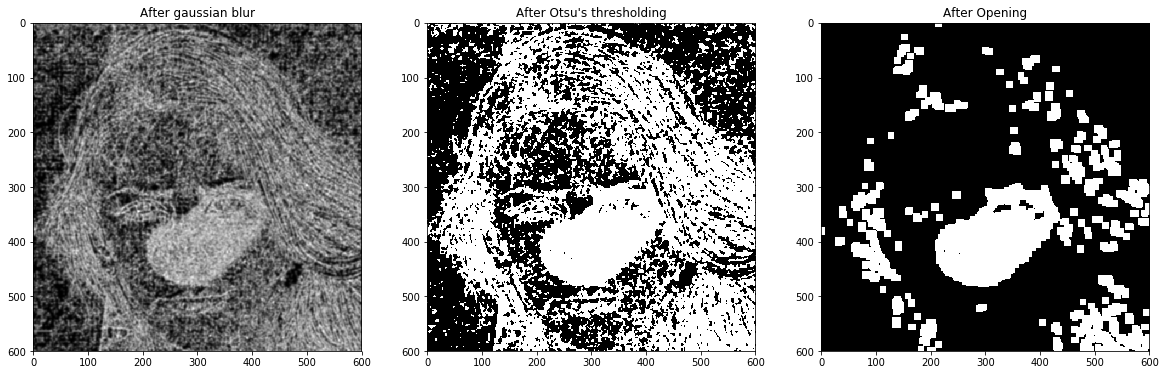

In [269]:
# Pipeline to help seeing the manipulated part of the image better. (Gaussian Blur -> Otsu's Threshold -> Opening)
plt.figure(figsize=(20,20))
blur = cv2.GaussianBlur(revealed_noises[0][:,:,0],(9,9),0)
plt.subplot(131); plt.imshow(blur, cmap='gray'); plt.title('After gaussian blur')
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.subplot(132); plt.imshow(th3, cmap='gray'); plt.title("After Otsu's thresholding")
kernel = np.ones((12,12),np.uint8)
opening = cv2.morphologyEx(th3, cv2.MORPH_OPEN, kernel)
plt.subplot(133); plt.imshow(opening, cmap='gray'); plt.title('After Opening')

## 3 - Error Level Analysis (ELA)

Text(0.5, 1.0, 'After Opening')

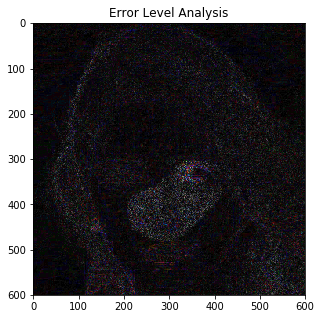

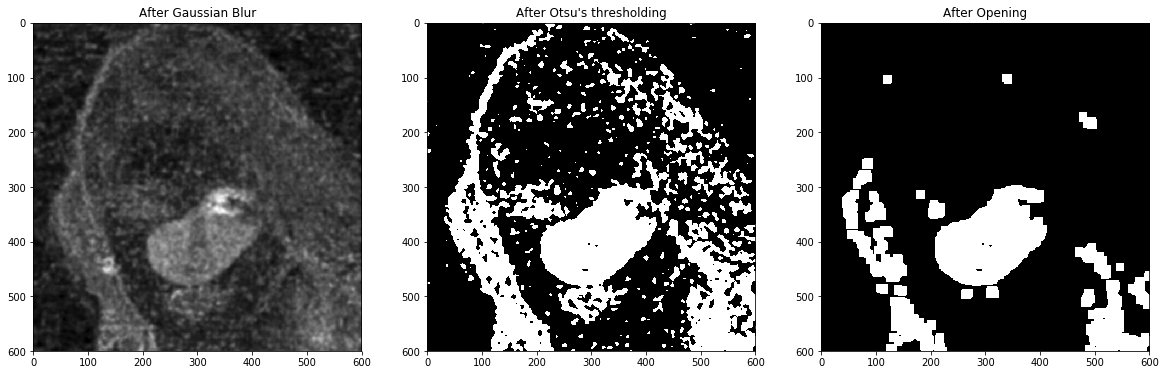

In [270]:
from PIL import Image, ImageChops, ImageEnhance
import sys, os.path

filename = img_path
resaved = filename + '.resaved.jpg'
ela = filename + '.ela.png'

im = Image.open(filename)

# Saves the image at 60% quality
im.save(resaved, 'JPEG', quality=60)
resaved_im = Image.open(resaved)

# Get the difference between the original and the resaved image
ela_im = ImageChops.difference(im, resaved_im)
extrema = ela_im.getextrema()
max_diff = max([ex[1] for ex in extrema])
scale = 255.0/max_diff

# Enhance Brighteness 
ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
ela_im = np.asarray(ela_im)

plt.figure(figsize=(5,5))
plt.imshow(ela_im)
plt.title('Error Level Analysis')


# Pipeline to help seeing the manipulated part of the image better. (Gaussian Blur -> Otsu's Threshold -> Opening)
plt.figure(figsize=(20,20))
blur = cv2.GaussianBlur(ela_im[:,:,0],(15,15),0)
plt.subplot(131); plt.imshow(blur, cmap='gray'); plt.title('After Gaussian Blur')
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.subplot(132); plt.imshow(th3, cmap='gray'); plt.title("After Otsu's thresholding")
kernel = np.ones((15,15),np.uint8)
opening = cv2.morphologyEx(th3, cv2.MORPH_OPEN, kernel)
plt.subplot(133); plt.imshow(opening, cmap='gray'); plt.title('After Opening')

## 4 - Simple filter methods

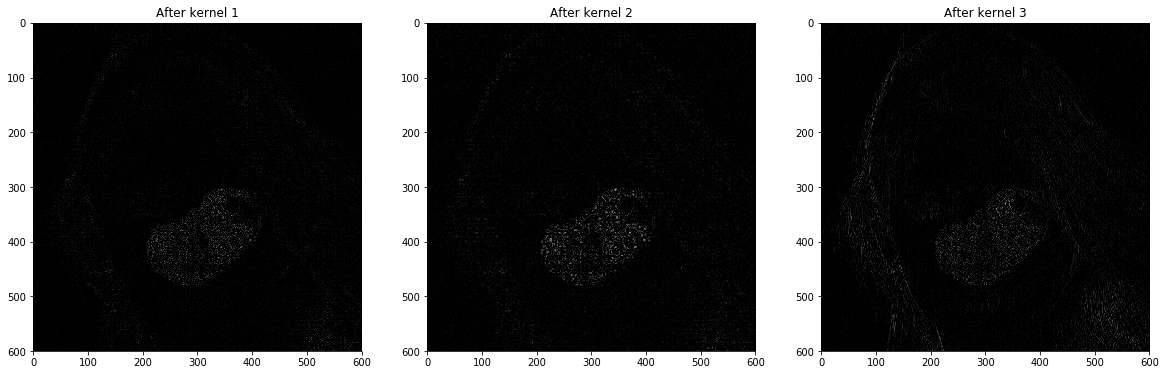

Text(0.5, 1.0, 'After Opening')

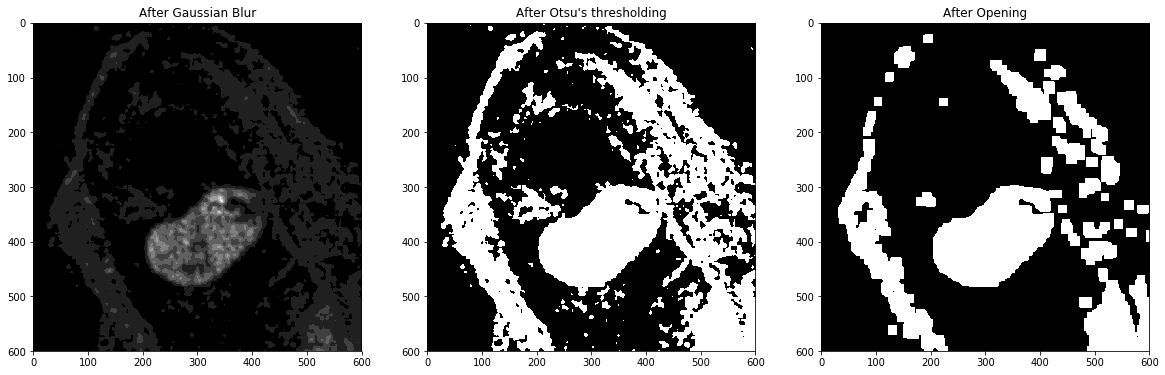

In [271]:
# SRM kernels

SRM_1 =  np.array((
    [ 0, 0, 0, 0, 0],
    [ 0,-1, 2,-1, 0],
    [ 0, 2,-4, 2, 0],
    [ 0,-1, 2,-1, 0],
    [ 0, 0, 0, 0, 0]), dtype="int") * 1/4
 
SRM_2 =  np.array((
    [-1, 2,-2, 2,-1],
    [ 2,-6, 8,-6, 2],
    [-2, 8,-12, 8,-2],
    [ 2,-6, 8,-6, 2],
    [-1, 2,-2, 2,-1]), dtype="int") * 1/12

SRM_3 =  np.array((
    [ 0, 0, 0, 0, 0],
    [ 0, 0, 0, 0, 0],
    [ 0, 1,-2, 1, 0],
    [ 0, 0, 0, 0, 0],
    [ 0, 0, 0, 0, 0]), dtype="int") * 1/2

plt.figure(figsize=(20,20))

# Convolve the R channel with SRM kernels
output_1 = cv2.filter2D(r, -1, SRM_1)
output_2 = cv2.filter2D(r, -1, SRM_2)
output_3 = cv2.filter2D(r, -1, SRM_3)

plt.subplot(131); plt.imshow(output_1, cmap='gray'); plt.title('After kernel 1')
plt.subplot(132); plt.imshow(output_2, cmap='gray'); plt.title('After kernel 2')
plt.subplot(133); plt.imshow(output_3, cmap='gray'); plt.title('After kernel 3')
plt.show()

# Pipeline to help seeing the manipulated part of the image better. (Gaussian Blur -> Otsu's Threshold -> Opening)
plt.figure(figsize=(20,20))
blur = cv2.GaussianBlur(output_1,(15,15),0)
plt.subplot(131); plt.imshow(blur, cmap='gray'); plt.title('After Gaussian Blur')
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.subplot(132); plt.imshow(th3, cmap='gray'); plt.title("After Otsu's thresholding")
kernel = np.ones((15,15),np.uint8)
opening = cv2.morphologyEx(th3, cv2.MORPH_OPEN, kernel)
plt.subplot(133); plt.imshow(opening, cmap='gray'); plt.title('After Opening')

## 5 - PCA and LBP (failed attempts)

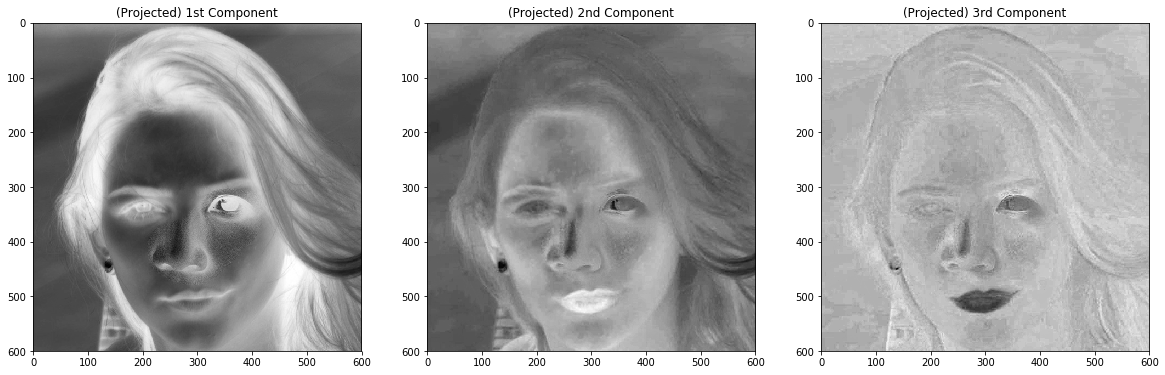

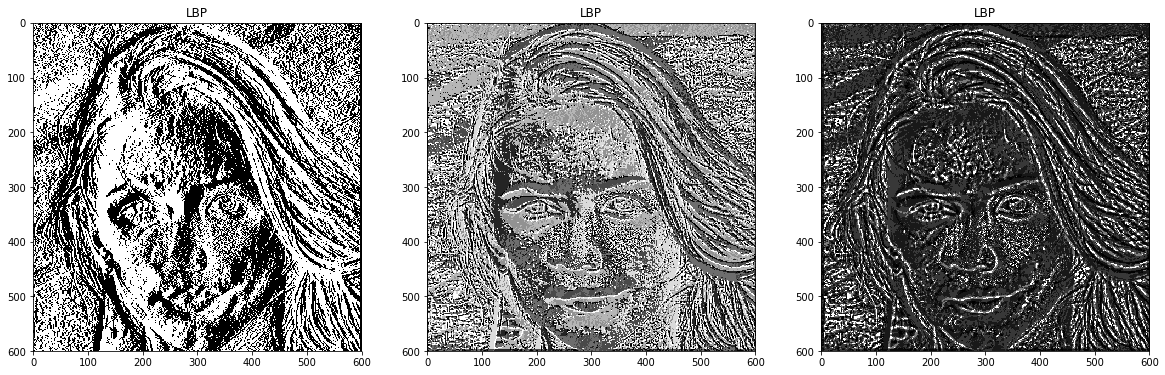

In [272]:
#### PCA ####
rows, cols, colors = img_bgr.shape

# flatten rows and cols into a single dimension
flattened = img_bgr.reshape((-1, colors)) 

# PCA is just the SVD of the covariance matrix
U, S, V = la.svd(np.cov(flattened.T))

PC1 = U[:,0] # 1st principle component
projected = np.dot(flattened,PC1)
pca1 = np.reshape( projected, (rows,cols)) # unflatten

PC2 = U[:,1] # 2nd principle component
projected = np.dot(flattened,PC2)
pca2 = np.reshape( projected, (rows,cols)) # unflatten

PC3 = U[:,2] # 3rd principle component
projected = np.dot(flattened,PC3)
pca3 = np.reshape( projected, (rows,cols)) # unflatten

plt.figure(figsize=(20,20))
plt.subplot(131); plt.imshow(pca1, cmap='gray'); plt.title('(Projected) 1st Component')
plt.subplot(132); plt.imshow(pca2, cmap='gray'); plt.title('(Projected) 2nd Component')
plt.subplot(133); plt.imshow(pca3, cmap='gray'); plt.title('(Projected) 3rd Component')
plt.show()


#### LBP ####
from skimage import feature

lbp1 = feature.local_binary_pattern(g, 1, 3, method="uniform")
lbp2 = feature.local_binary_pattern(g, 3, 3, method="default")
lbp3 = feature.local_binary_pattern(g, 5, 5, method="ror")

plt.figure(figsize=(20,20))
plt.subplot(131); plt.imshow(lbp1, cmap='gray'); plt.title('LBP')
plt.subplot(132); plt.imshow(lbp2, cmap='gray'); plt.title('LBP')
plt.subplot(133); plt.imshow(lbp3, cmap='gray'); plt.title('LBP')
plt.show()